<a href="https://colab.research.google.com/github/DepartmentOfStatisticsPUE/air-2020/blob/master/notebooks/10_analizy_przetrzenne.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Instalacja niezbędnych pakietów

In [0]:
!apt install libspatialindex-dev
!pip install -U pysal urbanaccess pandana

In [0]:
import numpy as np
import geopandas as gpd
import pandas as pd
import pysal as ps
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 10]

In [0]:
!unzip mapy.zip

Programujemy współczynnik autokorelacji przetrzennej I Morana

In [0]:
A = [[0, 1, 1, 1, 1], 
     [1, 0, 1, 0, 1],
     [1, 1, 0, 1, 0],
     [1, 0, 1, 0, 1],
     [1, 1, 0, 1, 0]]
A

[[0, 1, 1, 1, 1],
 [1, 0, 1, 0, 1],
 [1, 1, 0, 1, 0],
 [1, 0, 1, 0, 1],
 [1, 1, 0, 1, 0]]

In [0]:
Y = [5, 5, 5, 2, 2]
Y

[5, 5, 5, 2, 2]

Tworzymy macierz W - macierz przestrzenną (standaryzowaną wierszowo).

In [0]:
W = A / np.sum(A, axis = 1)
W = np.transpose(W)
W

array([[0.        , 0.25      , 0.25      , 0.25      , 0.25      ],
       [0.33333333, 0.        , 0.33333333, 0.        , 0.33333333],
       [0.33333333, 0.33333333, 0.        , 0.33333333, 0.        ],
       [0.33333333, 0.        , 0.33333333, 0.        , 0.33333333],
       [0.33333333, 0.33333333, 0.        , 0.33333333, 0.        ]])

Miara Morana

$$
I = n / S_0 \sum_i \sum_j z_i w_{ij} z_j / \sum_i z_i z_i
$$

$$
S_0 = \sum_i \sum_j w_{ij}
$$

In [0]:
Z = Y - np.mean(Y)

In [0]:
I = 5/np.sum(W)*np.sum(Z @ W @ Z)/np.sum(Z @ Z)
I

-0.05555555555555555

Drugi wzór na statystykę Morana

$$
I = \frac{n}{\sum_i \sum_j w_{ij}} 
\frac{\sum_i \sum_j w_{ij} z_i z_j }{\sum_i z_i^2}
$$

# Operacje na plikach


Wczytujemy dane o powiatach

In [124]:
pow_df=gpd.read_file("mapy/powiaty.shp")
pow_df.head(n=2)

,SP_ID,iip_przest,iip_identy,iip_wersja,jpt_sjr_ko,jpt_kod_je,jpt_nazwa_,jpt_nazw01,jpt_organ_,jpt_orga01,jpt_jor_id,wazny_od,wazny_do,jpt_wazna_,wersja_od,wersja_do,jpt_powier,jpt_kj_iip,jpt_kj_i01,jpt_kj_i02,jpt_kod_01,id_bufora_,id_bufor01,id_technic,jpt_opis,jpt_sps_ko,gra_ids,status_obi,opis_bledu,typ_bledu,geometry
0,0,PL.PZGIK.200,07f182b1-9146-43e5-a62d-836c211f9ff1,2012-09-27T07:36:28+02:00,POW,0226,powiat zÅotoryjski,None,None,NZN,0.0,None,None,6 NZN,None,2020-12-09,26.0,0000000000EGIB,0226,None,None,0.0,13888.0,0.0,829314,UZG,None,AKTUALNY,None,None,"POLYGON ((269083.616 370884.075, 269164.192 37..."
1,1,PL.PZGIK.200,c845cab0-9fbf-4123-9fc3-c70e57ad17fb,2012-09-27T07:36:28+02:00,POW,0262,powiat Legnica,None,None,NZN,0.0,None,None,6 NZN,None,2020-12-09,26.0,0000000000EGIB,0262,None,None,0.0,13888.0,0.0,829315,UZG,None,AKTUALNY,None,None,"POLYGON ((296226.609 372333.783, 296689.158 37..."


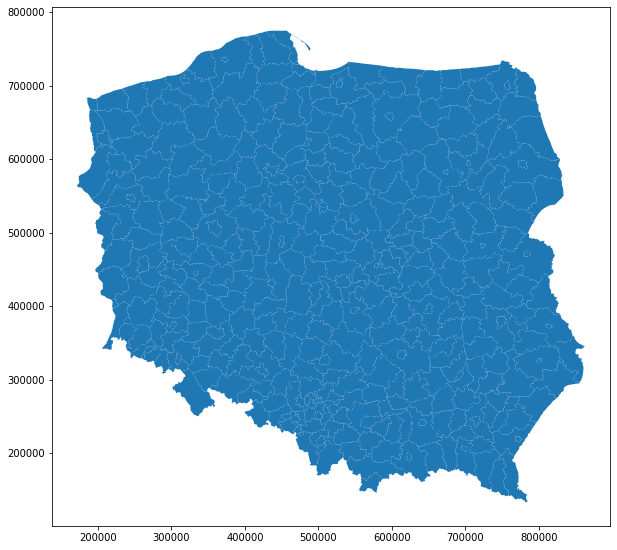

In [204]:
pow_df.plot()

Wczytujemy dane o wynagrodzeniach


In [166]:
pow_dane = pd.read_excel("powiaty_wynag.xlsx", sheet_name=1)
pow_dane_sub = pow_dane[["Kod", "Wartosc"]].copy()
pow_dane_sub["kod"]=pow_dane_sub.Kod.astype(str).str.zfill(7)
pow_dane_sub["kod"]=pow_dane_sub.kod.str.slice(0,4)
pow_dane_sub = pow_dane_sub.drop(columns = ["Kod"])
pow_dane_sub

,Wartosc,kod
0,4214.66,0201
1,4024.94,0202
2,4077.69,0203
3,3815.89,0204
4,4029.64,0205
...,...,...
375,4045.65,3217
376,4083.38,3218
377,4184.46,3261
378,5007.48,3262


Dodajemy dane o wynagrodzeniach do danych o mapie

In [170]:
pow_df = pd.merge(left = pow_df, right = pow_dane_sub, how = "left", left_on="jpt_kod_je", right_on = "kod")
pow_df.head(n=2)

,SP_ID,iip_przest,iip_identy,iip_wersja,jpt_sjr_ko,jpt_kod_je,jpt_nazwa_,jpt_nazw01,jpt_organ_,jpt_orga01,jpt_jor_id,wazny_od,wazny_do,jpt_wazna_,wersja_od,wersja_do,jpt_powier,jpt_kj_iip,jpt_kj_i01,jpt_kj_i02,jpt_kod_01,id_bufora_,id_bufor01,id_technic,jpt_opis,jpt_sps_ko,gra_ids,status_obi,opis_bledu,typ_bledu,geometry,Wartosc,kod
0,0,PL.PZGIK.200,07f182b1-9146-43e5-a62d-836c211f9ff1,2012-09-27T07:36:28+02:00,POW,0226,powiat zÅotoryjski,None,None,NZN,0.0,None,None,6 NZN,None,2020-12-09,26.0,0000000000EGIB,0226,None,None,0.0,13888.0,0.0,829314,UZG,None,AKTUALNY,None,None,"POLYGON ((269083.616 370884.075, 269164.192 37...",4362.98,0226
1,1,PL.PZGIK.200,c845cab0-9fbf-4123-9fc3-c70e57ad17fb,2012-09-27T07:36:28+02:00,POW,0262,powiat Legnica,None,None,NZN,0.0,None,None,6 NZN,None,2020-12-09,26.0,0000000000EGIB,0262,None,None,0.0,13888.0,0.0,829315,UZG,None,AKTUALNY,None,None,"POLYGON ((296226.609 372333.783, 296689.158 37...",4259.37,0262


Rysujemy mapę 

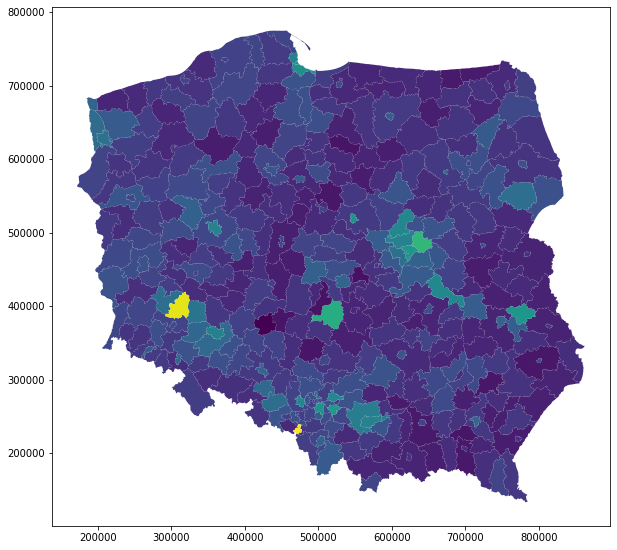

In [205]:
pow_df.plot(column = "Wartosc")

Posortujmy i zobaczmy

In [209]:
pow_df[["kod","jpt_nazwa_","Wartosc"]].sort_values(by = "Wartosc", ascending = False)

,kod,jpt_nazwa_,Wartosc
276,2467,powiat JastrzÄbie-ZdrÃ³j,8121.08
28,0211,powiat lubiÅski,7915.01
143,1465,powiat Warszawa,6432.78
63,1001,powiat beÅchatowski,6259.40
286,2468,powiat Jaworzno,5848.34
...,...,...,...
57,1018,powiat wieruszowski,3454.23
323,2812,powiat nowomiejski,3439.34
65,1003,powiat Åaski,3432.41
59,1021,powiat brzeziÅski,3385.89


In [0]:
Tworzymy macierz na podstawie danych wejściowych

In [175]:
w=ps.lib.weights.Rook.from_dataframe(pow_df)
w

Sprawdzamy wartość autokorelacji przestrzennej

In [215]:
 result = pysal.explore.esda.moran.Moran(pow_df["Wartosc"], w)
 print([result.I, result.p_norm])

[0.23141858847544294, 8.377076810006656e-12]


Sprawdzmy miary lokalne

In [216]:
result_local = pysal.explore.esda.moran.Moran_Local(pow_df["Wartosc"], w)
sum(result_local.p_sim < 0.05) ## ile istotnych statystycznie

91

Natysujemy te istotne statystycznie

In [220]:
pow_df["istotne"] = result_local.p_sim < 0.05
pow_df["hots_colds"] = result_local.q
pow_df["hotspots"] = result_local.q == 1 * pow_df["istotne"]
pow_df["coldspots"] = result_local.q == 3 * pow_df["istotne"]
pow_df[["kod","jpt_nazwa_","Wartosc", "istotne", "hots_colds", "istotne"]].head(n = 5)

,kod,jpt_nazwa_,Wartosc,istotne,hots_colds,istotne
0,0226,powiat zÅotoryjski,4362.98,False,4,False
1,0262,powiat Legnica,4259.37,False,1,False
2,0206,powiat jeleniogÃ³rski,4035.56,False,2,False
3,0204,powiat gÃ³rowski,3815.89,True,2,True
4,0214,powiat oleÅnicki,4128.29,False,3,False


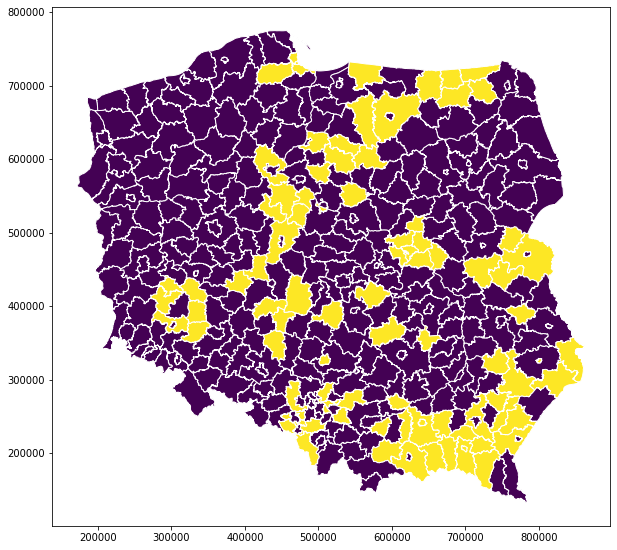

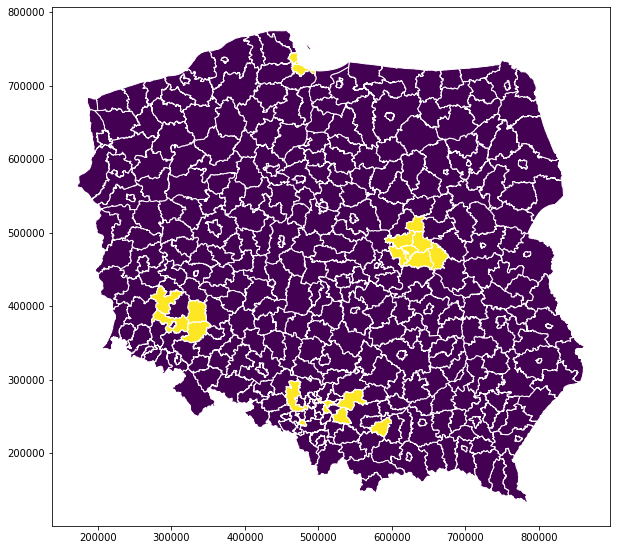

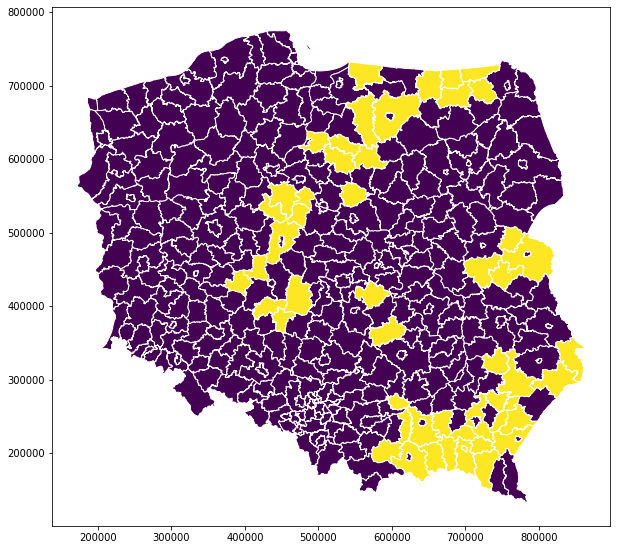

In [221]:
pow_df.plot(column = "istotne", edgecolor = "white")
pow_df.plot(column = "hotspots", edgecolor = "white")
pow_df.plot(column = "coldspots", edgecolor = "white")